In [1]:
import sys
import os

# Get the path to the parent directory (consumption)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import the LSTMModel from the dnn.models module
from dnn.models import MLPModel

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from data_preprocessing import process_resstock_data

# Load data

### Setpoint timeseries

In [3]:
# full_heating_timeseries, full_cooling_timeseries = generate_setpoint_timeseries(
#     cooling_start_date = "2018-06-01",
#     cooling_end_date = "2018-10-31",
#     combine = False
# )

In [4]:
# # Save heaitng and cooling timeseries to pickle
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_heating_timeseries, f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_cooling_timeseries, f)

In [5]:
# Load full heating and cooling timeseries
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
    full_heating_timeseries = pickle.load(f)
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
    full_cooling_timeseries = pickle.load(f)

### Weather data

In [6]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

### ResStock

In [7]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [8]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

In [9]:
heating_timeseries = full_heating_timeseries[1000]
cooling_timeseries = full_cooling_timeseries[1000]

heating_timeseries = pd.concat([heating_timeseries.loc["2018-01-01":"2018-05-31"], heating_timeseries.loc["2018-11-01":"2018-12-31"]])
cooling_timeseries = cooling_timeseries.loc["2018-06-01":"2018-10-31"]

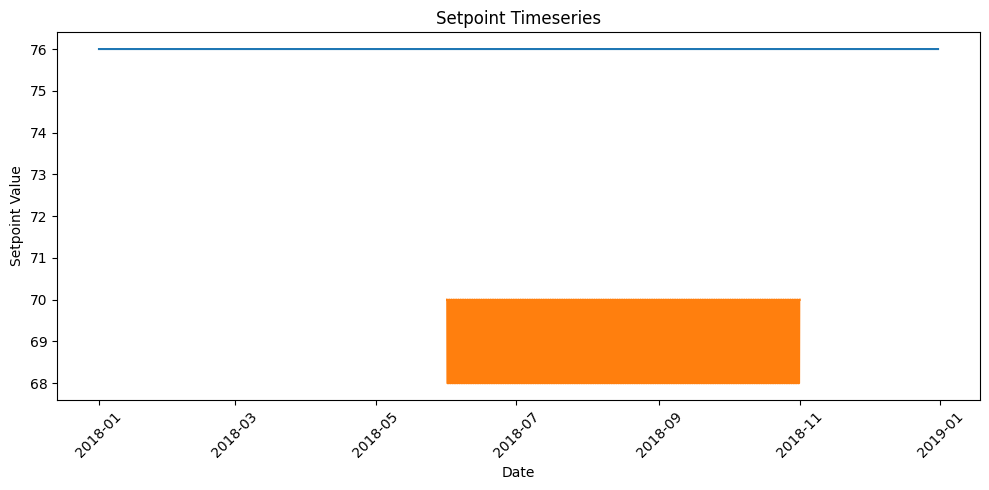

In [10]:
# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(heating_timeseries.index, heating_timeseries["setpoint"])
plt.plot(cooling_timeseries.index, cooling_timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ResStock transform

In [11]:
columns = [
    "in.bedrooms",              # int
    "in.duct_leakage_and_insulation",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location",         # Places of the house
    "in.geometry_floor_area",   # 1000-1499, ...
    "in.geometry_stories",      # int
    "in.geometry_wall_type",    # Materials
    "in.ground_thermal_conductivity",   # float
    "in.hvac_has_ducts",    # Yes / No
    "in.insulation_ceiling",    # R-n / Uninsulated
    "in.insulation_floor",      # R-n / Uninsulated
    "in.insulation_foundation_wall",    # Wall R-n, Exterior
    "in.insulation_roof",       # Finished / Unfinished, R-n
    "in.insulation_wall",       # Material, Uninsulated / R-n
    "in.occupants",         # int
    "in.orientation",       # North, Northwest...
    "in.roof_material",     # Material
    "in.sqft",              # int
    "in.windows"    # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas",
    "in.vintage",
]

In [12]:
columns_processed = [
    "in.bedrooms_processed",              # int
    "in.duct_leakage_processed",
    "in.duct_insulation_processed",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location_processed",         # Places of the house
    "in.geometry_floor_area_processed",   # 1000-1499, ...
    "in.geometry_stories_processed",      # int
    "in.geometry_wall_type_processed",    # Materials
    "in.ground_thermal_conductivity_processed",   # float
    "in.hvac_has_ducts_processed",    # Yes / No
    "in.insulation_ceiling_processed",    # R-n / Uninsulated
    "in.insulation_floor_processed",      # R-n / Uninsulated
    "in.insulation_foundation_wall_processed",    # Wall R-n, Exterior
    "in.insulation_roof_processed",       # Finished / Unfinished, R-n
    "in.insulation_wall_processed",       # Material, Uninsulated / R-n
    "in.occupants_processed",         # int
    "in.orientation_processed",       # North, Northwest...
    "in.roof_material_processed",     # Material
    "in.sqft_processed",              # int
    "in.windows_processed", # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas_processed",
    "in.vintage_processed",
    
]

In [13]:
resstock_processed = process_resstock_data(resstock)

In [14]:
resstock_processed["in.vintage_processed"].value_counts()

in.vintage_processed
1930    3820
1970    1386
1950    1312
1980    1269
1960    1220
1990     895
2000     825
1940     614
2010     366
Name: count, dtype: int64

In [15]:
usable_resstock = resstock_processed[columns_processed]

In [16]:
usable_resstock.head()

,in.bedrooms_processed,in.duct_leakage_processed,in.duct_insulation_processed,in.duct_location_processed,in.geometry_floor_area_processed,in.geometry_stories_processed,in.geometry_wall_type_processed,in.ground_thermal_conductivity_processed,in.hvac_has_ducts_processed,in.insulation_ceiling_processed,...,in.insulation_foundation_wall_processed,in.insulation_roof_processed,in.insulation_wall_processed,in.occupants_processed,in.orientation_processed,in.roof_material_processed,in.sqft_processed,in.windows_processed,in.window_areas_processed,in.vintage_processed
bldg_id,,,,,,,,,,,,,,,,,,,,,
10,3,10,0,4,1749,1,1,1.4,1,5,...,1,0,0,6,1,3,1228,2,18,1950
122,1,0,0,0,874,5,1,1.4,0,0,...,1,6,0,1,5,0,623,2,18,1950
129,1,0,0,0,874,2,2,1.1,0,0,...,1,5,1,1,4,0,623,1,15,1970
150,2,0,0,0,1749,3,1,1.1,0,0,...,0,3,4,1,3,0,1138,2,15,2000
183,3,0,0,0,1749,1,1,1.4,0,1,...,1,0,0,2,3,1,1228,2,18,1930


In [17]:
building_resstock = np.array(usable_resstock.loc[1000])

In [18]:
building_resstock

array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.000e+00,
       2.000e+00, 1.400e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       5.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.682e+03,
       2.000e+00, 1.500e+01, 1.930e+03])

# Transform data

In [19]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [20]:
weather_data.columns

Index(['date_time', 'Dry Bulb Temperature [°C]', 'Relative Humidity [%]',
       'Wind Speed [m/s]', 'Wind Direction [Deg]',
       'Global Horizontal Radiation [W/m2]', 'Direct Normal Radiation [W/m2]',
       'Diffuse Horizontal Radiation [W/m2]'],
      dtype='object')

In [21]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]", "Direct Normal Radiation [W/m2]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [22]:
weather_data.bfill(inplace=True)
weather_data.ffill(inplace=True)

In [23]:
building_id = 1000

In [24]:
col_to_use = get_cols(resstock, building_id)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_33012/3969840236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_33012/3969840236.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  consumption_timeseries = consumption_timeseries.resample("H").mean()


In [25]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [26]:
heating_exog = exog_variables.loc[heating_timeseries.index]
cooling_exog = exog_variables.loc[cooling_timeseries.index]

# Data Plot

In [27]:
train_size = 0.8
heating_endog_train = heating_timeseries[:int(train_size * len(heating_timeseries))]
heating_endog_test = heating_timeseries[int(train_size * len(heating_timeseries)):]

heating_exog_train = heating_exog[:int(train_size * len(heating_exog))]
heating_exog_test = heating_exog[int(train_size * len(heating_exog)):]

cooling_endog_train = cooling_timeseries[:int(train_size * len(cooling_timeseries))]
cooling_endog_test = cooling_timeseries[int(train_size * len(cooling_timeseries)):]

cooling_exog_train = cooling_exog[:int(train_size * len(cooling_exog))]
cooling_exog_test = cooling_exog[int(train_size * len(cooling_exog)):]

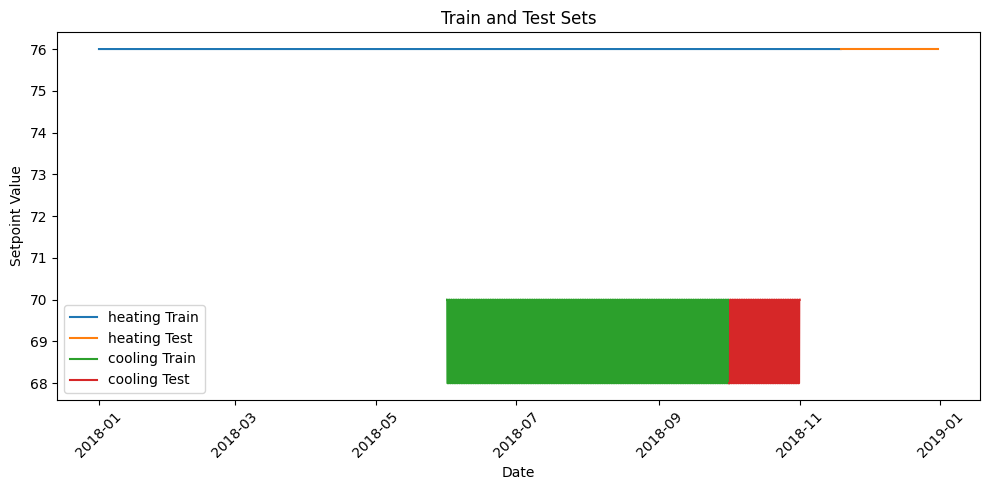

In [28]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="heating Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="heating Test")
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="cooling Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="cooling Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Datasets and Dataloaders

In [29]:
heating_train_timeseries = pd.merge(heating_endog_train, heating_exog_train, left_index=True, right_index=True)
heating_test_timeseries = pd.merge(heating_endog_test, heating_exog_test, left_index=True, right_index=True)

cooling_train_timeseries = pd.merge(cooling_endog_train, cooling_exog_train, left_index=True, right_index=True)
cooling_test_timeseries = pd.merge(cooling_endog_test, cooling_exog_test, left_index=True, right_index=True)

In [30]:
heating_train_timeseries.head()

,setpoint,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,,
2018-01-01 00:00:00,76.0,4.691970,-17.2,0.0
2018-01-01 01:00:00,76.0,5.008804,-17.2,0.0
2018-01-01 02:00:00,76.0,4.799112,-17.8,0.0
2018-01-01 03:00:00,76.0,4.963452,-18.9,0.0
2018-01-01 04:00:00,76.0,5.047929,-18.9,0.0


In [31]:
def create_lr_sequences(data, sequence_length, building_resstock):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length - 1):
        sequence = np.array(data.iloc[i:i+sequence_length])
        label = data.iloc[i+sequence_length].iloc[0]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), labels

In [32]:
sequence_length = 12
batch_size = 64

heating_train_sequences, heating_train_labels = create_lr_sequences(heating_train_timeseries, sequence_length, building_resstock)
heating_test_sequences, heating_test_labels = create_lr_sequences(heating_test_timeseries, sequence_length, building_resstock)

cooling_train_sequences, cooling_train_labels = create_lr_sequences(cooling_train_timeseries, sequence_length, building_resstock)
cooling_test_sequences, cooling_test_labels = create_lr_sequences(cooling_test_timeseries, sequence_length, building_resstock)

In [33]:
heating_train_sequences = heating_train_sequences.reshape(heating_train_sequences.shape[0], -1)
heating_test_sequences = heating_test_sequences.reshape(heating_test_sequences.shape[0], -1)

cooling_train_sequences = cooling_train_sequences.reshape(cooling_train_sequences.shape[0], -1)
cooling_test_sequences = cooling_test_sequences.reshape(cooling_test_sequences.shape[0], -1)

In [34]:
building_resstock_repeated_heating_train = np.tile(building_resstock, (heating_train_sequences.shape[0], 1))
building_resstock_repeated_heating_test = np.tile(building_resstock, (heating_test_sequences.shape[0], 1))

building_resstock_repeated_cooling_train = np.tile(building_resstock, (cooling_train_sequences.shape[0], 1))
building_resstock_repeated_cooling_test = np.tile(building_resstock, (cooling_test_sequences.shape[0], 1))

In [35]:
heating_train_sequences = np.concatenate((heating_train_sequences, building_resstock_repeated_heating_train), axis=1)
heating_test_sequences = np.concatenate((heating_test_sequences, building_resstock_repeated_heating_test), axis=1)

cooling_train_sequences = np.concatenate((cooling_train_sequences, building_resstock_repeated_cooling_train), axis=1)
cooling_test_sequences = np.concatenate((cooling_test_sequences, building_resstock_repeated_cooling_test), axis=1)

In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [37]:
heating_train_dataset = TimeSeriesDataset(heating_train_sequences, heating_train_labels)
heating_test_dataset = TimeSeriesDataset(heating_test_sequences, heating_test_labels)
heating_train_loader = DataLoader(heating_train_dataset, batch_size=batch_size, shuffle=True)
heating_test_loader = DataLoader(heating_test_dataset, batch_size=batch_size, shuffle=False)

cooling_train_dataset = TimeSeriesDataset(cooling_train_sequences, cooling_train_labels)
cooling_test_dataset = TimeSeriesDataset(cooling_test_sequences, cooling_test_labels)
cooling_train_loader = DataLoader(cooling_train_dataset, batch_size=batch_size, shuffle=True)
cooling_test_loader = DataLoader(cooling_test_dataset, batch_size=batch_size, shuffle=False)

# Train and evaluate fns

In [38]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [39]:
# Predict
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [40]:
len(heating_train_dataset[0][0])

69

# MLP

In [41]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [42]:
heating_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [43]:
# Loss and optimizer
heating_criterion = nn.MSELoss()
heating_optimizer = optim.Adam(heating_model.parameters(), lr=0.0001)

## Heating

In [44]:
num_epochs = 100
train(heating_model, heating_train_loader, heating_criterion, heating_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 1766.9645
Epoch 2/100, Loss: 73.6540
Epoch 3/100, Loss: 35.1246
Epoch 4/100, Loss: 19.5950
Epoch 5/100, Loss: 11.7432
Epoch 6/100, Loss: 7.6611
Epoch 7/100, Loss: 5.6240
Epoch 8/100, Loss: 4.3162
Epoch 9/100, Loss: 3.6419
Epoch 10/100, Loss: 3.1804
Epoch 11/100, Loss: 2.8361
Epoch 12/100, Loss: 2.4984
Epoch 13/100, Loss: 2.2405
Epoch 14/100, Loss: 2.0773
Epoch 15/100, Loss: 1.8872
Epoch 16/100, Loss: 1.7503
Epoch 17/100, Loss: 1.6366
Epoch 18/100, Loss: 1.5250
Epoch 19/100, Loss: 1.4661
Epoch 20/100, Loss: 1.3456
Epoch 21/100, Loss: 1.3038
Epoch 22/100, Loss: 1.2125
Epoch 23/100, Loss: 1.1298
Epoch 24/100, Loss: 1.0621
Epoch 25/100, Loss: 1.0138
Epoch 26/100, Loss: 0.9468
Epoch 27/100, Loss: 0.9092
Epoch 28/100, Loss: 0.8672
Epoch 29/100, Loss: 0.8277
Epoch 30/100, Loss: 0.7981
Epoch 31/100, Loss: 0.7599
Epoch 32/100, Loss: 0.7242
Epoch 33/100, Loss: 0.6971
Epoch 34/100, Loss: 0.6589
Epoch 35/100, Loss: 0.6443
Epoch 36/100, Loss: 0.6102
Epoch 37/100, Loss: 0.5965
Epo

In [45]:
# Predict
heating_predictions, heating_actuals = evaluate(heating_model, heating_test_loader)

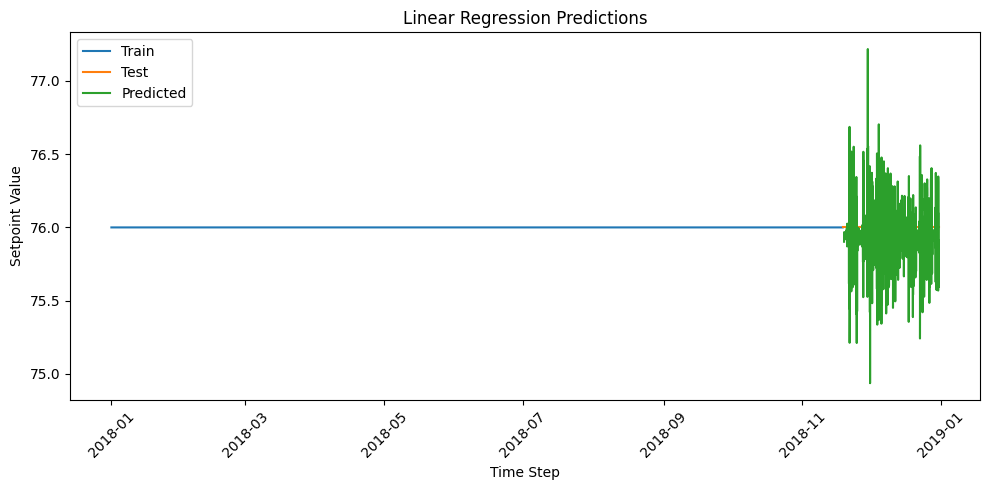

In [46]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
plt.plot(heating_test_timeseries.index[13:], heating_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [47]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [48]:
cooling_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [49]:
# Loss and optimizer
cooling_criterion = nn.MSELoss()
cooling_optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [50]:
num_epochs = 100
train(cooling_model, cooling_train_loader, cooling_criterion, cooling_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 657.7366
Epoch 2/100, Loss: 57.9857
Epoch 3/100, Loss: 26.9572
Epoch 4/100, Loss: 13.0009
Epoch 5/100, Loss: 7.6444
Epoch 6/100, Loss: 5.4650
Epoch 7/100, Loss: 4.4954
Epoch 8/100, Loss: 3.8861
Epoch 9/100, Loss: 3.5239
Epoch 10/100, Loss: 3.3007
Epoch 11/100, Loss: 3.1111
Epoch 12/100, Loss: 2.9538
Epoch 13/100, Loss: 2.8506
Epoch 14/100, Loss: 2.7369
Epoch 15/100, Loss: 2.6353
Epoch 16/100, Loss: 2.5870
Epoch 17/100, Loss: 2.4572
Epoch 18/100, Loss: 2.3922
Epoch 19/100, Loss: 2.3133
Epoch 20/100, Loss: 2.2741
Epoch 21/100, Loss: 2.2007
Epoch 22/100, Loss: 2.1705
Epoch 23/100, Loss: 2.0985
Epoch 24/100, Loss: 2.0453
Epoch 25/100, Loss: 2.0163
Epoch 26/100, Loss: 1.9583
Epoch 27/100, Loss: 1.9215
Epoch 28/100, Loss: 1.8715
Epoch 29/100, Loss: 1.8461
Epoch 30/100, Loss: 1.8345
Epoch 31/100, Loss: 1.7888
Epoch 32/100, Loss: 1.7792
Epoch 33/100, Loss: 1.7359
Epoch 34/100, Loss: 1.7174
Epoch 35/100, Loss: 1.6777
Epoch 36/100, Loss: 1.6612
Epoch 37/100, Loss: 1.6398
Epoch

In [51]:
# Predict
cooling_predictions, cooling_actuals = evaluate(cooling_model, cooling_test_loader)

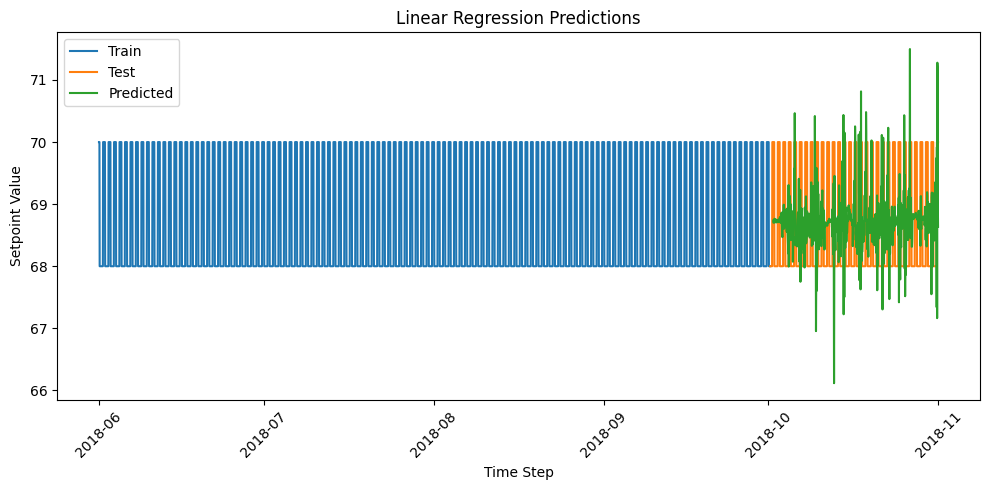

In [52]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Akaike

In [53]:
def compute_aic(y_true, y_pred, num_params):
    n = y_true.numel()
    residuals = y_true - y_pred
    rss = torch.sum(residuals ** 2).item()
    sigma2 = rss / n
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    return aic

In [54]:
heating_num_params = sum(p.numel() for p in heating_model.parameters() if p.requires_grad)

In [55]:
heating_aic = compute_aic(
    torch.tensor(heating_actuals), 
    torch.tensor(heating_predictions), 
    heating_num_params
)

In [56]:
heating_aic

np.float64(19675.892341062125)

In [57]:
cooling_num_params = sum(p.numel() for p in cooling_model.parameters() if p.requires_grad)
cooling_aic = compute_aic(
    torch.tensor(cooling_actuals), 
    torch.tensor(cooling_predictions), 
    cooling_num_params
)
cooling_aic

np.float64(20085.716105671712)